<a href="https://colab.research.google.com/github/shuyu-wu/bitcoin-prediction/blob/master/bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load libraries

In [0]:
import pandas as pd
# from langdetect import detect, DetectorFactory
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,RNN,GRU
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pickle
from keras.models import load_model
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Load real time dataset

In [0]:
tweets_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/tweets_v1.csv')

In [0]:
tweets_df.text.isnull().sum()

718

In [0]:
tweets_df.text.dropna(inplace=True)

# Filter English tweets

In [0]:
def filter_english (x):
    try:
        if detect(x) == 'en':
            return x
        else:
            return 0
    except: return 0

In [0]:
tw = tweets_df.copy()
tw['text'] = tw.text.apply(filter_english)

In [0]:
tw.shape

(1851563, 10)

In [0]:
tw.tail()

,user,fullname,tweet-id,timestamp,url,likes,replies,retweets,text,html
1851558,hanamoto7839,与沢翼ファンクラブ,1085491142202781696,2019-01-16 10:57:10,/hanamoto7839/status/1085491142202781696,2,0,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851559,skskwwwww,S(つд⊂)さく,1085491133143179265,2019-01-16 10:57:08,/skskwwwww/status/1085491133143179265,1,0,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851560,BTC_shoshinsha,ツーカー,1085491126495137792,2019-01-16 10:57:06,/BTC_shoshinsha/status/1085491126495137792,2,1,0,0,"<p class=""TweetTextSize js-tweet-text tweet-te..."
1851561,HRleaderRich,Rich Brown,1085491114906398720,2019-01-16 10:57:03,/HRleaderRich/status/1085491114906398720,0,0,0,"""Bitcoin - A method of secure transactions bas...","<p class=""TweetTextSize js-tweet-text tweet-te..."
1851562,BotDjulian,Djulian [Bot],1085491108665163777,2019-01-16 10:57:02,/BotDjulian/status/1085491108665163777,3,0,4,MARKET BRAZIL CC SHOP [http://54ce5x7l4m3t2spm...,"<p class=""TweetTextSize js-tweet-text tweet-te..."


In [0]:
tw.to_csv('/content/drive/My Drive/Colab Notebooks/preprocessed.csv')


In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/preprocessed.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,4,5,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
prepr_df = prepr_df.loc[prepr_df['text']!='0']

In [0]:
prepr_df.head()

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...


In [0]:
prepr_df.to_csv('/content/drive/My Drive/Colab Notebooks/prepr.csv')

In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/prepr.csv')

In [0]:
prepr_df=prepr_df[['timestamp','text']]

In [0]:
prepr_df.head()

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...


# Loading train labeled dataset

In [0]:
labeled_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bitcointweets.csv',header=None)

In [0]:
labeled_df.head()

,0,1,2,3,4,5,6,7
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,16522,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral']
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,1295,0,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral']
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,6090,0,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,184,0,[],"<a href=""http://twitter.com/download/android"" ...",['positive']


In [0]:
labeled_df = labeled_df[[0,1,7]]
labeled_df.columns = ['date','tweets','sentiment']

['positive']    45.099196
['neutral']     43.136908
['negative']    11.763896
Name: sentiment, dtype: float64

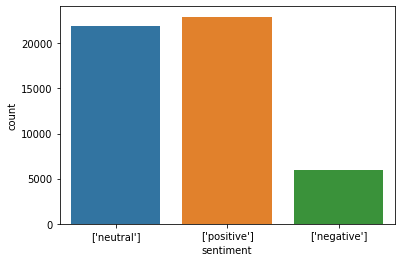

In [0]:
sns.countplot(labeled_df['sentiment'])
labeled_df['sentiment'].value_counts(normalize=True) * 100

In [0]:
labeled_df['date'] = pd.to_datetime(labeled_df['date'])

In [0]:
def clean_text(s):
    s = re.sub(r'http\S+', '', str(s))
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', str(s))
    s = re.sub(r'@\S+', '', str(s))
    s = re.sub('&amp', ' ', str(s))
    return s

In [0]:
labeled_df['clean_tweets'] = labeled_df['tweets'].apply(clean_text)

In [0]:
labeled_df.drop(['tweets'],axis=1, inplace=True)

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

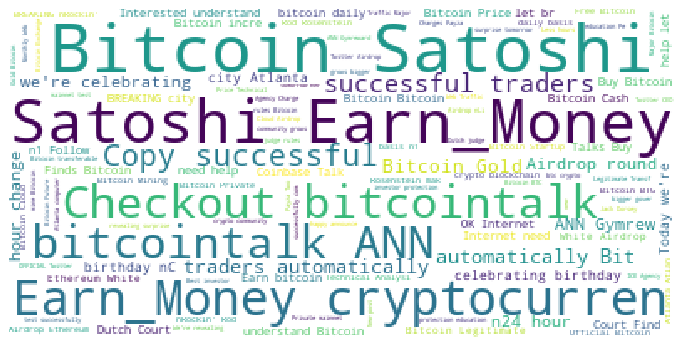

In [0]:
text = labeled_df["clean_tweets"].to_string()
wordcloud = WordCloud(relative_scaling=0.5 , background_color='white',stopwords=set(stopwords.words('english'))).generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Train Test Split

In [0]:
X = labeled_df["clean_tweets"]
y = pd.get_dummies(labeled_df["sentiment"].values)
y.head()

,['negative'],['neutral'],['positive']
0,0,1,0
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [0]:
y = np.array(y)
num_classes = labeled_df["sentiment"].nunique()

In [0]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 , random_state = 42)


In [0]:
X_train

28589    #cryptkeeper How much money can bitcoin miners...
15363    You love your laptop, but its WiFi network ada...
10609     : #Bitcoin #Satoshi #Earn_Money #cryptocurren...
29157     : Here reporting from Blockchain  ; Bitcoin C...
9683      : #Bitcoin #cryptocurrency  #Airdrop\nNew Air...
                               ...                        
11284    TRON (TRX) Airdrop Free 352 USD\n#airdrop #bou...
44732     : We have been attending a lot of conferences...
38158    Shocking, Secret Facts Part IIII  $btcusd #bit...
860                                2) whispered.\n#bitcoin
15795     : Official Bitcoin Cloud #Airdrop 1\n\n\n\nLi...
Name: clean_tweets, Length: 40687, dtype: object

In [0]:
y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]], dtype=uint8)

# Tokenize the words

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

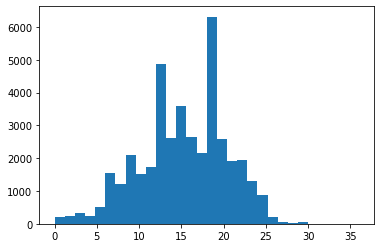

In [0]:
totalNumWords = [len(one_cleaned_tweet) for one_cleaned_tweet in X_train]
plt.hist(totalNumWords,bins=30)
plt.show()

In [0]:
max_words = max(totalNumWords)
X_train = sequence.pad_sequences(X_train , maxlen = max_words)
X_test = sequence.pad_sequences(X_test , maxlen = max_words)
print(X_train.shape,X_test.shape)

(40687, 36) (10172, 36)


# Construct model

## Baseline model - Random Forest

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train , test_size=0.2, random_state=42)


In [0]:
random_forest = RandomForestClassifier(random_state=123)
random_forest.fit(X_train,y_train)
print(random_forest.score(X_train, y_train))
print(random_forest.score(X_val, y_val))

0.9999078312697779
0.8354632587859425


## GRU model

In [0]:
def get_model_gru(max_features , embed_dim):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features , embed_dim , input_length=X_train.shape[1]))
    model.add(GRU(100 , dropout=0.2 , recurrent_dropout=0.2))
    model.add(Dense(num_classes , activation='softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    print(model.summary())
    return model

In [0]:
max_features = 20000
embed_dim =100
gru_model = get_model_gru(max_features,embed_dim)
model_train(gru_model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,060,603
Trainable params: 2,060,603
Non-trainable params: 0
_________________________________________________________________
None
Train on 32549 samples, validate on 10172 samples
Epoch 1/3
 - 31s - loss: 0.3659 - acc: 0.8637 - val_loss: 0.1211 - val_acc: 0.9632
Epoch 2/3
 - 30s - loss: 0.0700 - acc: 0.9803 - val_loss: 0.0956 - val_acc: 0.9734
Epoch 3/3
 - 30s - loss: 0.0299 - acc: 0.9919 - val_loss: 0.1012 - val_acc: 0.9757


Predicted  [0 0 1 ... 1 0 2]
True  [0 0 1 ... 1 0 2]
Accuracy:	97.6%


              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1164
           1       0.97      0.98      0.98      4345
           2       0.98      0.98      0.98      4663

    accuracy                           0.98     10172
   macro avg       0.97      0.96      0.97     10172
weighted avg       0.98      0.98      0.98     10172



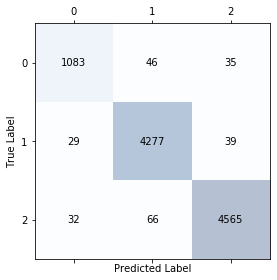

In [0]:
model_evaluate(gru_model)

## LSTM model

In [0]:
batch_size = 128
epochs = 3

In [0]:
def get_model(max_features , embed_dim):
    np.random.seed(42)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features , embed_dim , input_length=X_train.shape[1]))
    model.add(LSTM(100 , dropout=0.2 , recurrent_dropout=0.2))
    model.add(Dense(num_classes , activation='softmax'))
    model.compile(loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    print(model.summary())
    return model

In [0]:
def model_train(model):
    #training the model
    model_history = model.fit(X_train , y_train , validation_data = (X_test , y_test), 
                              epochs = epochs ,batch_size= batch_size,verbose = 2)
    return model_history

In [0]:
max_features = 20000
embed_dim =100
lstm_model = get_model(max_features,embed_dim)
lstm_model_train(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 36, 100)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 2,080,703
Trainable params: 2,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 32549 samples, validate on 10172 samples
Epoch 1/3
 - 38s - loss: 0.3843 - acc: 0.8500 - val_loss: 0.1341 - val_acc: 0.9569
Epoch 2/3
 - 36s - loss: 0.0726 - acc: 0.9791 - val_loss: 0.0962 - val_acc: 0.9714
Epoch 3/3
 - 36s - loss: 0.0297 - acc: 0.9918 - val_loss: 0.1080 - val_acc: 0.9729


## Evaluate on test dataset

In [0]:
def model_evaluate(model):
    #predict classes with test set
    y_pred_test = model.predict_classes(X_test , batch_size = batch_size, verbose =0)
    print("Predicted ", y_pred_test)
    print("True " , np.argmax(y_test,axis = 1))
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis = 1),y_pred_test)*100))
    
    #Classification Report
    print("\n")
    print(classification_report(np.argmax(y_test, axis =1),y_pred_test))
    
    #Confusion Matrix
    confmat = confusion_matrix(np.argmax(y_test , axis = 1), y_pred_test)
    fig , ax = plt.subplots(figsize=(4,4))
    ax.matshow(confmat , cmap =plt.cm.Blues , alpha = 0.3)
    
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text( x = j , y = i , s =confmat[i,j] , va = 'center' , ha = 'center')
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

Predicted  [0 0 1 ... 1 0 2]
True  [0 0 1 ... 1 0 2]
Accuracy:	97.3%


              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1164
           1       0.96      0.99      0.98      4345
           2       0.99      0.97      0.98      4663

    accuracy                           0.97     10172
   macro avg       0.97      0.96      0.96     10172
weighted avg       0.97      0.97      0.97     10172



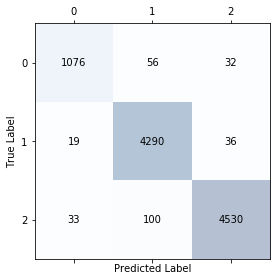

In [0]:
model_evaluate(lstm_model)

# Store model

In [0]:
pickle.dump(model, open("gru_model_v1.p", "wb"))

# Pre-trained NLTK model

In [0]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
prepr_df

,Unnamed: 0,timestamp,clean_tweets
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...
...,...,...,...
3294884,3707951,2019-01-16 10:57:11,What the #Bitcoin #Pizza is worth today! …
3294885,3707952,2019-01-16 10:57:11,Bankrupt Bitcoin Miner Giga Watt Forced to Cea...
3294886,3707953,2019-01-16 10:57:11,#crypto #bitcoin #blockchain …
3294887,3707957,2019-01-16 10:57:03,"""Bitcoin - A method of secure transactions bas..."


In [0]:
sid = SentimentIntensityAnalyzer()
sentiment_score = sid.polarity_scores(labeled_df['clean_tweets'][1])

In [0]:
sentiment_score

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

In [0]:
%time   #to calulate the time it takes the algorithm to compute a VADER score
i=0 #counter
compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores
while (i<len(labeled_df)):

    k = sid.polarity_scores(labeled_df.iloc[i]['clean_tweets'])
    compval1.append(k['compound'])    
    i = i+1   
#converting sentiment values to numpy for easier usage
compval1 = np.array(compval1)
len(compval1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


50859

In [0]:
labeled_df['VADER_score'] = compval1

In [0]:
labeled_df.head()

,date,sentiment,clean_tweets,VADER_score
0,2018-03-23 00:40:32+00:00,['neutral'],": Paul Krugman, Nobel Luddite. I had to tweak...",-0.6808
1,2018-03-23 00:40:34+00:00,['neutral'],But (dum b a ss) said you know nothing ab...,0.0000
2,2018-03-23 00:40:35+00:00,['positive'],: Another use case for #blockchain and #Tippe...,0.0000
3,2018-03-23 00:40:36+00:00,['positive'],free coins,0.5106
4,2018-03-23 00:40:36+00:00,['positive'],: WE are happy to announce that PayVX Presale...,0.6114


In [0]:
%time
#Assigning score categories and logic
i = 0
predicted_value = [ ] #empty series to hold our predicted values
while(i<len(labeled_df)):
    if ((labeled_df.iloc[i]['VADER_score'] >= 0.2)):
        predicted_value.append('positive')
        i = i+1
    elif ((labeled_df.iloc[i]['VADER_score'] >= -0.5) & (labeled_df.iloc[i]['VADER_score'] < 0.2)):
        predicted_value.append('neutral')
        i = i+1
    else:
        predicted_value.append('negative')
        i = i+1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [0]:
labeled_df['predicted_sentiment'] = predicted_value

In [0]:
labeled_df.tail(50)

,date,sentiment,clean_tweets,VADER_score,predicted_sentiment
50809,2018-03-23 08:54:56+00:00,['positive'],: Great news! Aeron Pilot application now in ...,0.6588,positive
50810,2018-03-23 08:54:58+00:00,['positive'],: Here reporting from Blockchain ; Bitcoin C...,0.8977,positive
50811,2018-03-23 08:55:00+00:00,['neutral'],5 min #RSI Signals:\n\n$BTC - $BRK: 1.02\n$BTC...,0.0000,neutral
50812,2018-03-23 08:55:00+00:00,['positive'],: We are very pleased to announce we are star...,0.9268,positive
50813,2018-03-23 08:55:00+00:00,['positive'],The latest Chatback #Security News! Thanks to...,0.4926,positive
50814,2018-03-23 08:55:00+00:00,['negative'],Bitcoin Will Be World's 'Single Currency' Says...,0.0000,neutral
50815,2018-03-23 08:55:02+00:00,['neutral'],College students are using student loans to in...,0.0000,neutral
50816,2018-03-23 08:55:02+00:00,['positive'],: After a successful launch of our Bounty cam...,0.5859,positive
50817,2018-03-23 08:55:02+00:00,['neutral'],: It's been 72 hours since the official launc...,0.3818,positive
50818,2018-03-23 08:55:03+00:00,['negative'],: Use the code: HF18BDAY30 at purchase to get...,-0.2263,neutral


# Load best performed model

In [0]:
lstm_model = pickle.load(open("gru_model_v1.p", "rb"))

In [0]:
prepr_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/cleanprep.csv',header=None)

In [0]:
prepr_df.head()
prepr_df.rename(columns={0:'timestamp',2:'text'},inplace=True)

In [0]:
prepr_df.drop(columns=[1,3,4],inplace=True)

In [0]:
prepr_df.head()

,timestamp,text
0,2018-07-11 19:35:15.363270,"b""Next two weeks prob v boring (climb up to 9k..."
1,2018-07-11 19:35:15.736769,b'@Miss_rinola But you\xe2\x80\x99ve heard abo...
2,2018-07-11 19:35:15.744769,b'Duplicate skilled traders automatically with...
3,2018-07-11 19:35:15.867339,b'Project Manager - Technical - FinTech - Cent...
4,2018-07-11 19:35:16.021448,"b'Coinbase App Downloads Drop, Crypto Hype Fad..."


## Initialize the real time dataset



In [0]:
prepr_df['clean_tweets'] = prepr_df['text'].apply(clean_text)
prepr_df.drop(['text'],axis=1, inplace=True)

In [0]:
X_prepr = prepr_df["clean_tweets"]

In [0]:
X_prepr = tokenizer.texts_to_sequences(X_prepr)
X_prepr = sequence.pad_sequences(X_prepr , maxlen = max_words)

# Model prediction

In [0]:
y_prepr = model.predict_classes(X_prepr , batch_size = batch_size, verbose =0)
prepr_df['sentiment'] = y_prepr

In [0]:
prepr_df

,Unnamed: 0,timestamp,clean_tweets,sentiment
0,0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...,2
1,1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...,1
2,2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...,1
3,3,2016-06-25 23:59:15,What are the merits and risks of investing in ...,1
4,4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...,1
...,...,...,...,...
3294884,3707951,2019-01-16 10:57:11,What the #Bitcoin #Pizza is worth today! …,2
3294885,3707952,2019-01-16 10:57:11,Bankrupt Bitcoin Miner Giga Watt Forced to Cea...,1
3294886,3707953,2019-01-16 10:57:11,#crypto #bitcoin #blockchain …,1
3294887,3707957,2019-01-16 10:57:03,"""Bitcoin - A method of secure transactions bas...",2


1    80.015472
2    15.465164
0     4.519363
Name: sentiment, dtype: float64

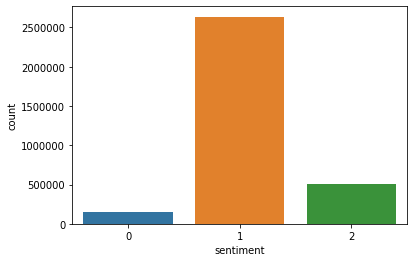

In [0]:
sns.countplot(prepr_df['sentiment'])
prepr_df['sentiment'].value_counts(normalize=True) * 100

In [0]:
# pd.get_dummies(prepr_df['sentiment'])
prepr_df = pd.concat([prepr_df,pd.get_dummies(prepr_df['sentiment'], prefix='sentiment')],axis=1)
prepr_df.drop(['sentiment'],axis=1,inplace=True)

In [0]:
prepr_df.rename(columns={'sentiment_0':'negative','sentiment_1':'neutral','sentiment_2':'positive',})

,timestamp,clean_tweets,negative,neutral,positive
0,2016-06-25 23:59:52,Bitcoin: Pissed-off customers sue GAW Miners i...,0,0,1
1,2016-06-25 23:59:36,I'm not gone lie I be staring at pplwhat btc's...,0,1,0
2,2016-06-25 23:59:17,Did you miss Beyond Bitcoin Hangout? I CANNOT ...,0,1,0
3,2016-06-25 23:59:15,What are the merits and risks of investing in ...,0,1,0
4,2016-06-25 23:59:08,Hash Ocean #Bitcoin Cloud Mining №1 in the wor...,0,1,0
...,...,...,...,...,...
3294884,2019-01-16 10:57:11,What the #Bitcoin #Pizza is worth today! …,0,0,1
3294885,2019-01-16 10:57:11,Bankrupt Bitcoin Miner Giga Watt Forced to Cea...,0,1,0
3294886,2019-01-16 10:57:11,#crypto #bitcoin #blockchain …,0,1,0
3294887,2019-01-16 10:57:03,"""Bitcoin - A method of secure transactions bas...",0,0,1


In [0]:
prepr_df.timestamp = pd.to_datetime(prepr_df.timestamp)


In [0]:
prepr_df.timestamp

0         2016-06-25 23:59:52
1         2016-06-25 23:59:36
2         2016-06-25 23:59:17
3         2016-06-25 23:59:15
4         2016-06-25 23:59:08
                  ...        
3294884   2019-01-16 10:57:11
3294885   2019-01-16 10:57:11
3294886   2019-01-16 10:57:11
3294887   2019-01-16 10:57:03
3294888   2019-01-16 10:57:02
Name: timestamp, Length: 3294889, dtype: datetime64[ns]

In [0]:
prepr_df = prepr_df.sort_values(by='timestamp')

In [0]:
prepr_df=prepr_df[prepr_df.clean_tweets!='nan']


In [0]:
prepr_df.reset_index(drop=True,inplace=True)

In [0]:
prepr_df

,timestamp,clean_tweets,sentiment_0,sentiment_1,sentiment_2
0,2016-02-26 22:03:17,My monster has 75 hp left! I've earned a total...,0,1,0
1,2016-02-26 22:03:19,"By joining our forves, TOGETHER we can change ...",0,1,0
2,2016-02-26 22:03:28,"""using bitcoin"" is the new ""on the internet""",0,0,1
3,2016-02-26 22:03:29,aims at maintaining competitive exchange r...,0,0,1
4,2016-02-26 22:03:40,First successful Zero-Knowledge Contingent Pay...,0,0,1
...,...,...,...,...,...
2596583,2019-03-28 23:59:41,#BITCOIN #TWITTER sentiment analysis: Today PO...,1,0,0
2596584,2019-03-28 23:59:43,"Hey, check this out: [Bitcoin and Ethereum Hit...",0,1,0
2596585,2019-03-28 23:59:52,London Metal Exchange Supports Plan for Blockc...,0,1,0
2596586,2019-03-28 23:59:53,You put a lot of thought into this tweet.,0,1,0


In [0]:
new_df = prepr_df.groupby(prepr_df.timestamp.dt.to_period('Min')).sum()


In [0]:
new_df.reset_index(inplace=True)

In [0]:
new_df.timestamp

,timestamp,sentiment_0,sentiment_1,sentiment_2
0,2016-02-26 22:03,0.0,7.0,4.0
1,2016-02-26 22:04,0.0,38.0,0.0
2,2016-02-26 22:05,0.0,31.0,2.0
3,2016-02-26 22:06,2.0,32.0,1.0
4,2016-02-26 22:07,2.0,5.0,13.0
...,...,...,...,...
58206,2019-03-28 23:55,2.0,5.0,5.0
58207,2019-03-28 23:56,3.0,8.0,7.0
58208,2019-03-28 23:57,0.0,11.0,6.0
58209,2019-03-28 23:58,3.0,12.0,4.0


In [0]:
new_df.timestamp[58111]

Period('2019-01-27 23:59', 'T')